In [1]:
%pylab inline
from imgaug import augmenters as iaa
import imgaug as ia

import pandas as pd
from sklearn import metrics
import scipy.linalg 

import sys
sys.path.insert(0, "..")
import pictureweb.distributed.sharded_matrix as sharded_matrix
import pictureweb.distributed.distributed as D 
from pictureweb.conv.coates_ng_help import grab_patches
import boto3
import io

Populating the interactive namespace from numpy and matplotlib


In [356]:
def evaluate_augmented(preds, augment_idxs, unaugmented_size, augmented_size=10):
    sort_idxs = np.argsort(augment_idxs)
    sort_preds = preds[sort_idxs]
    out_preds = None
    for i in range(augmented_size):
        idxs = np.where(((np.arange(sort_preds.shape[0]) - i) % augmented_size) == 0)
        print(idxs[0])
        if (out_preds == None):
            out_preds = sort_preds[idxs]
        else:
            out_preds += sort_preds[idxs]
    out_preds /= augmented_size
    return out_preds

def preprocess(train, test, min_divisor=1e-8, zca_bias=0.1, whitening_means=None, global_ZCA=None):
    origTrainShape = train.shape
    origTestShape = test.shape

    train = np.ascontiguousarray(train, dtype=np.float64).reshape(train.shape[0], -1)
    test = np.ascontiguousarray(test, dtype=np.float64).reshape(test.shape[0], -1)


    nTrain = train.shape[0]

    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]
    test = test - np.mean(test, axis=1)[:,np.newaxis]

    # Normalize
    train_norms = np.linalg.norm(train, axis=1)/55.0
    test_norms = np.linalg.norm(test, axis=1)/55.0

    # Get rid of really small norms
    train_norms[np.where(train_norms < min_divisor)] = 1
    test_norms[np.where(test_norms < min_divisor)] = 1

    # Make features unit norm
    train = train/train_norms[:,np.newaxis]
    test = test/test_norms[:,np.newaxis]
    whitening_means = np.mean(train, axis=0)

    zeroCenterTrain = (train - whitening_means[np.newaxis, :])

    trainCovMat = 1.0/nTrain * zeroCenterTrain.T.dot(zeroCenterTrain)

    (E,V) = np.linalg.eig(trainCovMat)
    E += zca_bias
    sqrt_zca_eigs = np.sqrt(E)
    inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
    global_ZCA = V.dot(inv_sqrt_zca_eigs).dot(V.T) 
    train = (train - whitening_means).dot(global_ZCA)
    test = (test - whitening_means).dot(global_ZCA)

    return (train.reshape(origTrainShape), test.reshape(origTestShape), whitening_means, global_ZCA) 
    

In [3]:
cifar = np.load("cifar_raw.npz")

In [154]:
X_train = cifar['X_train'].transpose(0,2,3,1)
X_test = cifar['X_test'].transpose(0,2,3,1)
y_train = cifar['y_train']
y_test = cifar['y_test']


In [30]:
a = None
b = None

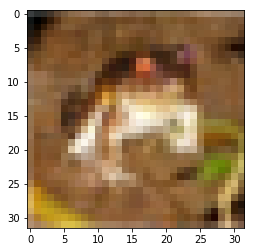

In [156]:
imshow(X_train[0])

In [357]:
X_train_flat = X_train.transpose(0,3,1,2).reshape(X_train.shape[0], -1).astype('float64')
X_test_flat = X_test.transpose(0,3,1,2).reshape(X_test.shape[0], -1).astype('float64')
X_test_flat_2 = D.get_local_matrix(X_test_sharded)
X_train_flat, X_test_flat, whitening_means, global_ZCA = preprocess(X_train_flat, X_test_flat)
XtX = X_train_flat.T.dot(X_train_flat)
Xty = X_train_flat.T.dot(y_train_enc)
model = scipy.linalg.solve(XtX + np.eye(XtX.shape[0])*1e-8, Xty, sym_pos=True)
print(metrics.accuracy_score(np.argmax(X_train_flat.dot(model),axis=1), y_train))
print(metrics.accuracy_score(np.argmax(X_test_flat.dot(model),axis=1), y_test))
print(metrics.accuracy_score(np.argmax(X_test_flat_2.dot(model),axis=1), y_test))


0.50324
0.3594
0.3594


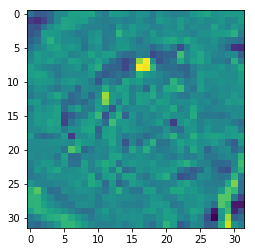

In [315]:
imshow(X_train_flat.reshape(-1,3,32,32).transpose(0,2,3,1)[0, :, :, 0])

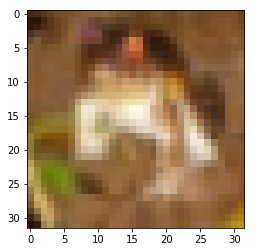

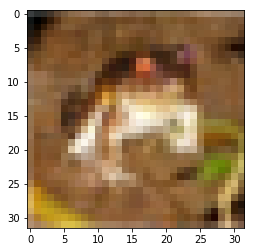

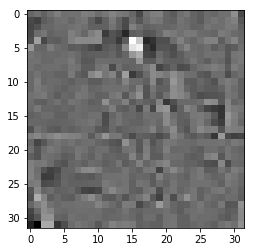

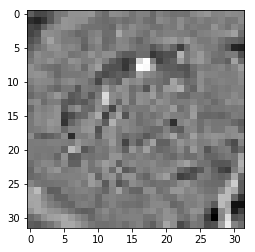

In [328]:
imshow(X_train_augmented[0])
plt.figure()
imshow(X_train[0])
plt.figure()
imshow(X_train_augmented_flat.reshape(-1,3,32,32).transpose(0,2,3,1)[0, :, :, 0], cmap=plt.cm.gray)
plt.figure()
imshow(X_train_flat.reshape(-1,3,32,32).transpose(0,2,3,1)[0, :, :, 0], cmap=plt.cm.gray)

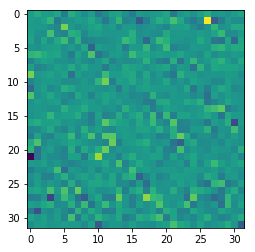

In [312]:
imshow(X_train_augmented_flat.reshape(-1,32,32,3)[0, :, :, 1])
imshow(X_train_flat.reshape(-1,3,32,32).transpose(0,2,3,1)[0, :, :, 0])
imshow(X_train_flat.reshape(-1,3,32,32).transpose(0,2,3,1)[0, :, :, 0])
imshow(X_train_augmented_flat.reshape(-1,3,32,32).transpose(0,2,3,1)[0, :, :, 0], cmap=plt.cm.gray)

In [358]:
%time X_train_sharded  = sharded_matrix.ShardedMatrix("cifar_train", bucket="pictureweb", shard_size_0=4096, data=X_train_flat, reshard=True, n_jobs=32)
%time X_test_sharded  = sharded_matrix.ShardedMatrix("cifar_test", bucket="pictureweb", shard_size_0=4096, data=X_test_flat, reshard=True, n_jobs=32)

Sharding matrix..... of shape (50000, 3072)
409608192122881638420480     819224576 122881638420480  4096   00 000  0   30723072 30723072

3072


24576 28672 0 3072
30722867232768409603686449152     50000
32768368644505640960     00000    3072307230723072



45056 49152 0  30723072

CPU times: user 13.5 s, sys: 3.27 s, total: 16.8 s
Wall time: 22.9 s
Sharding matrix..... of shape (10000, 3072)
8192 409610000  81920  3072
00 4096 0 3072 3072

CPU times: user 1.75 s, sys: 620 ms, total: 2.37 s
Wall time: 6.54 s


In [330]:
seq = iaa.Sequential([
    iaa.Crop(px=((0, 4), (0, 4), (0, 4), (0, 4))),
    iaa.Fliplr(0.5)])

In [331]:
seq.reseed(0)

In [332]:
AUGMENT = 10

In [333]:
%time X_train_augmented = np.vstack([seq.augment_images(X_train) for _ in range(AUGMENT)])

CPU times: user 1min 30s, sys: 3.12 s, total: 1min 33s
Wall time: 1min 33s


In [334]:
seq.reseed(0)

In [335]:
%time X_test_augmented = np.vstack([seq.augment_images(X_test) for _ in range(AUGMENT)])

CPU times: user 17.7 s, sys: 164 ms, total: 17.8 s
Wall time: 17.8 s


In [336]:
augment_idxs_no_scramble = np.hstack([list(range(X_train.shape[0])) for _ in range(AUGMENT)])

In [337]:
augment_idxs_test_no_scramble = np.hstack([list(range(X_test.shape[0])) for _ in range(AUGMENT)])

In [338]:
%time y_train_augmented = np.hstack([y_train for _ in range(AUGMENT)])

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 964 µs


In [339]:

%time y_test_augmented = np.hstack([y_test for _ in range(AUGMENT)])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 820 µs


In [340]:
%time y_train_augmented_enc = np.eye(10)[y_train_augmented]

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 19.1 ms


In [341]:
X_train_augmented_flat = X_train_augmented.transpose(0,3,1,2).reshape(X_train_augmented.shape[0], -1).astype('float64')
X_test_augmented_flat = X_test_augmented.transpose(0,3,1,2).reshape(X_test_augmented.shape[0], -1).astype('float64')

In [342]:
X_train_augmented_flat, X_test_augmented_flat, whitening_means, global_ZCA = preprocess(X_train_augmented_flat, X_test_augmented_flat)

In [255]:
XtX_augmented = X_train_augmented_flat.T.dot(X_train_augmented_flat)

In [256]:
Xty_augmented = X_train_augmented_flat.T.dot(y_train_augmented_enc)

In [257]:
model_augmented = scipy.linalg.solve(XtX_augmented, Xty_augmented)
preds_train_augmented = X_train_augmented_flat.dot(model_augmented)
preds_test_augmented = X_test_augmented_flat.dot(model_augmented)

In [258]:
print(preds_test_augmented.shape)

(100000, 10)


In [265]:
np.random.seed(0)
train_idxs = np.random.choice(X_train_augmented.shape[0], X_train_augmented.shape[0], replace=False)
test_idxs = np.random.choice(X_test_augmented.shape[0], X_test_augmented.shape[0], replace=False)

In [266]:
metrics.accuracy_score(np.argmax(X_test_augmented_flat.dot(model_augmented), axis=1), y_test_augmented)

0.37751000000000001

In [267]:
preds_averaged_0 = evaluate_augmented(preds_test_augmented, augment_idxs_test_no_scramble, X_test.shape[0], augmented_size=AUGMENT)

[    0    10    20 ..., 99970 99980 99990]
[    1    11    21 ..., 99971 99981 99991]
[    2    12    22 ..., 99972 99982 99992]
[    3    13    23 ..., 99973 99983 99993]
[    4    14    24 ..., 99974 99984 99994]
[    5    15    25 ..., 99975 99985 99995]
[    6    16    26 ..., 99976 99986 99996]
[    7    17    27 ..., 99977 99987 99997]
[    8    18    28 ..., 99978 99988 99998]
[    9    19    29 ..., 99979 99989 99999]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [268]:
metrics.accuracy_score(np.argmax(preds_averaged_0, axis=1), y_test)

0.40589999999999998

In [269]:
y_train_augmented

array([6, 9, 9, ..., 9, 1, 1])

In [270]:
X_train_augmented_shuffled = X_train_augmented_flat[train_idxs]
X_test_augmented_shuffled = X_test_augmented_flat[test_idxs]
y_train_augmented_shuffled = y_train_augmented[train_idxs]
augment_idxs_scramble = augment_idxs_no_scramble[train_idxs]

In [271]:
y_test_augmented_shuffled = y_test_augmented[test_idxs]

In [272]:
%time XtX_augmented_shuffled = X_train_augmented_shuffled.T.dot(X_train_augmented_shuffled)
y_train_augmented_shuffled_enc = np.eye(10)[y_train_augmented_shuffled]
%time Xty_augmented_shuffled = X_train_augmented_shuffled.T.dot(y_train_augmented_shuffled_enc)


CPU times: user 4min 8s, sys: 0 ns, total: 4min 8s
Wall time: 10.2 s
CPU times: user 27.5 s, sys: 112 ms, total: 27.6 s
Wall time: 942 ms


In [274]:
model = scipy.linalg.solve(XtX_augmented_shuffled + np.eye(XtX_augmented_shuffled.shape[0]), Xty_augmented_shuffled, sym_pos=True)

In [275]:
preds_test_augmented = X_test_augmented_shuffled.dot(model)
preds_train_augmented = X_train_augmented_shuffled.dot(model)
print(metrics.accuracy_score(np.argmax(preds_train_augmented, axis=1), y_train_augmented_shuffled))

0.404348


In [276]:
preds_averaged = evaluate_augmented(preds_test_augmented, augment_idxs_test_no_scramble[test_idxs], X_test.shape[0], augmented_size=AUGMENT)

[    0    10    20 ..., 99970 99980 99990]
[    1    11    21 ..., 99971 99981 99991]
[    2    12    22 ..., 99972 99982 99992]
[    3    13    23 ..., 99973 99983 99993]
[    4    14    24 ..., 99974 99984 99994]
[    5    15    25 ..., 99975 99985 99995]
[    6    16    26 ..., 99976 99986 99996]
[    7    17    27 ..., 99977 99987 99997]
[    8    18    28 ..., 99978 99988 99998]
[    9    19    29 ..., 99979 99989 99999]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [277]:
print(metrics.accuracy_score(np.argmax(preds_averaged, axis=1), y_test))

0.4059


In [278]:
client = boto3.client('s3')

In [279]:
bio = io.BytesIO()
np.save(bio, augment_idxs_test_no_scramble[test_idxs])
client.put_object(Bucket="pictureweb", Key="cifar/cifar_test_augment_idxs", Body=bio.getvalue())



{'ETag': '"0630d5d1a209746a3920754a8fab4b1d"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Wed, 12 Jul 2017 19:18:34 GMT',
   'etag': '"0630d5d1a209746a3920754a8fab4b1d"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'cYROgXazE50x8u1lXHitTyhn56ettBeZDF6qnZmkr/PWSk5xKinY3ddicsXB3uZ5bjebPpIyo6o=',
   'x-amz-request-id': 'E15809528DB65093'},
  'HTTPStatusCode': 200,
  'HostId': 'cYROgXazE50x8u1lXHitTyhn56ettBeZDF6qnZmkr/PWSk5xKinY3ddicsXB3uZ5bjebPpIyo6o=',
  'RequestId': 'E15809528DB65093',
  'RetryAttempts': 0}}

In [280]:
augment_idxs_no_scramble[train_idxs]

array([44257, 46319, 38738, ..., 35829,  5711, 11484])

In [281]:
bio = io.BytesIO()
np.save(bio, augment_idxs_no_scramble[train_idxs])
client.put_object(Bucket="pictureweb", Key="cifar/cifar_train_augment_idxs", Body=bio.getvalue())

bio = io.BytesIO()
np.save(bio, y_test_augmented_shuffled)
client.put_object(Bucket="pictureweb", Key="cifar/cifar_augmented_test_labels", Body=bio.getvalue())

{'ETag': '"f58660d205e4bcce42a36695b5b79b92"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Wed, 12 Jul 2017 19:18:40 GMT',
   'etag': '"f58660d205e4bcce42a36695b5b79b92"',
   'server': 'AmazonS3',
   'x-amz-id-2': '4POuvpVPfJtZXtlZC7JgKKL3SS+xMwZBy+bZ+bfPOOZYgRIBCRRQw11OmmhCzsJtAbu8ou07ag4=',
   'x-amz-request-id': '54B45064188DF7DF'},
  'HTTPStatusCode': 200,
  'HostId': '4POuvpVPfJtZXtlZC7JgKKL3SS+xMwZBy+bZ+bfPOOZYgRIBCRRQw11OmmhCzsJtAbu8ou07ag4=',
  'RequestId': '54B45064188DF7DF',
  'RetryAttempts': 0}}

In [282]:
bio = io.BytesIO()
np.save(bio, y_train_augmented_shuffled)
client.put_object(Bucket="pictureweb", Key="cifar/cifar_augmented_train_labels", Body=bio.getvalue())


bio = io.BytesIO()
np.save(bio, y_test)
client.put_object(Bucket="pictureweb", Key="cifar/cifar_test_labels", Body=bio.getvalue())

bio = io.BytesIO()
np.save(bio, y_train)
client.put_object(Bucket="pictureweb", Key="cifar/cifar_train_labels", Body=bio.getvalue())

{'ETag': '"c335bfbdf66baa3803235db2957ef000"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Wed, 12 Jul 2017 19:18:41 GMT',
   'etag': '"c335bfbdf66baa3803235db2957ef000"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'KK+UiHNF+u9XcU0xHZBZnCJWrNtuOLuMsygMhhTvjQvax9kIjF/4Budg0KVeEOBJglFtPv6Aw4c=',
   'x-amz-request-id': '10D6E398C0C778B2'},
  'HTTPStatusCode': 200,
  'HostId': 'KK+UiHNF+u9XcU0xHZBZnCJWrNtuOLuMsygMhhTvjQvax9kIjF/4Budg0KVeEOBJglFtPv6Aw4c=',
  'RequestId': '10D6E398C0C778B2',
  'RetryAttempts': 0}}

In [283]:
%time X_train_augmented_sharded = sharded_matrix.ShardedMatrix("cifar_augmented_train", bucket="pictureweb", data=X_train_augmented_shuffled, reshard=True, n_jobs=32)

Sharding matrix..... of shape (500000, 3072)
3686481920245764096040962048032768163841228857344491522867245056614406553653248                6963240960 4096286724505681922457636864204801638461440532483276849152655366963257344  12288               73728778248601673728819201064961024009420898304901121187841228801105921146881269760 000000000000000                0               08192090112778248601611059210649698304102400942081228801269761146881187841310723072 307230723072307230723072307230723072307230723072307230723072               
3072














307200000000000000 
             
30723072307230723072307230723072307230723072307230723072













131072 135168 0 3072
143360139264147456135168   147456 151552139264 143360  0 00 0  3072 30723072
3072


151552 155648 0 3072
155648 159744 159744 1638400  3072
0 3072
163840 167936167936  0 3072
172032 176128 0176128172032   0180224  3072
30720 1843201802243072 
 188416
188416 184320  19251200   030723072 

3072
192512 196608 0 200704307

HI


In [292]:
%time X_test_sharded = sharded_matrix.ShardedMatrix("cifar_augmented_test", bucket="pictureweb", data=X_test_augmented_shuffled, reshard=True, n_jobs=32)

Sharding matrix..... of shape (100000, 3072)
8192122880  4096 16384 12288 0  03072 0409616384245765734436864204804096045056327682867253248614409830449152696329420881920737289011265536
3072                     8601677824 
30728192204802867261440409602457669632450564915236864327685734465536100000532487372898304860167782494208 9011281920
                      0000000000000000000000                     3072307230723072 30723072307230723072307230723072307230723072307230723072307230723072



3072

















CPU times: user 38.9 s, sys: 6.45 s, total: 45.3 s
Wall time: 16 s


In [66]:
X_train_augmented_shuffled.reshape(-1, 3, 32, 32)

array([[[[ -2.79897596e-01,  -4.57884115e-01,  -3.40901860e-01, ...,
           -6.84194228e-01,  -5.90550134e-01,  -5.72298641e-01],
         [ -1.37989180e-01,  -1.11981216e-01,  -7.66968713e-02, ...,
           -2.78999758e-01,  -6.07077225e-01,  -7.07030016e-01],
         [  2.73108334e-02,  -2.13672179e-02,  -8.38932878e-03, ...,
           -9.45645957e-02,  -2.42655265e-01,  -7.46501786e-01],
         ..., 
         [ -3.94526148e-01,  -3.64428681e-01,  -4.14348916e-01, ...,
            1.64281168e-01,   7.98406038e-02,   2.23038761e-01],
         [ -3.23213607e-01,  -2.76471398e-01,  -3.12830391e-01, ...,
           -1.15253120e-01,  -2.21210511e-01,   1.67703865e-01],
         [ -4.07535263e-01,  -4.83018033e-02,  -8.15439810e-02, ...,
           -2.69165207e-01,  -4.15285410e-01,  -9.25134940e-02]],

        [[  1.29916940e-01,   1.80994988e-01,   2.70627473e-01, ...,
           -1.46230388e-01,   1.37902252e-03,   9.74283146e-02],
         [  1.09441682e-01,   1.05126690e-01,

In [399]:
%time X_train_featurized_sharded = sharded_matrix.ShardedMatrix("coatesng_1024_6_1_15_6_1.0_0(cifar_train)", bucket="pictureweb")
%time X_train_featurized = D.get_local_matrix(X_train_featurized_sharded)

CPU times: user 92 ms, sys: 8 ms, total: 100 ms
Wall time: 150 ms
CPU times: user 32 ms, sys: 9.4 s, total: 9.43 s
Wall time: 21 s


In [402]:
%time X_test_featurized_sharded = sharded_matrix.ShardedMatrix("coatesng_1024_6_1_15_6_1.0_0(cifar_test)", bucket="pictureweb")
%time X_test_featurized = D.get_local_matrix(X_test_featurized_sharded)

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 182 ms
CPU times: user 28 ms, sys: 3.75 s, total: 3.78 s
Wall time: 11.1 s


In [403]:
X_train_featurized

memmap([[  5.11947632e+00,   6.03134298e+00,   5.41807222e+00, ...,
          9.56388935e-03,   7.04079587e-03,   1.69738363e-02],
       [  5.76031685e+00,   6.78766441e+00,   6.49284220e+00, ...,
          7.74326473e-02,   2.72383820e-02,   5.68682998e-02],
       [  4.31526232e+00,   4.31874561e+00,   4.12526608e+00, ...,
          1.04394334e-03,   0.00000000e+00,   2.18922249e-03],
       ..., 
       [  4.69338369e+00,   4.25618982e+00,   5.83814383e+00, ...,
          3.17508006e-03,   0.00000000e+00,   6.16400037e-03],
       [  3.04304242e+00,   3.66782546e+00,   3.46440506e+00, ...,
          9.21915472e-02,   6.28304854e-02,   2.76121181e-02],
       [  6.37246799e+00,   5.35065031e+00,   4.37123013e+00, ...,
          1.20084696e-02,   6.29259087e-03,   6.39286498e-03]])

In [404]:
X_test_featurized

memmap([[  9.56578350e+00,   9.52307415e+00,   6.11063814e+00, ...,
          1.71856433e-02,   3.65733565e-03,   7.57780159e-03],
       [  3.45247149e+00,   3.60839128e+00,   3.78253555e+00, ...,
          3.60945947e-02,   2.23309454e-02,   8.01606162e-04],
       [  3.00875783e+00,   3.78432512e+00,   4.94803762e+00, ...,
          1.71737134e-04,   0.00000000e+00,   1.69772783e-03],
       ..., 
       [  2.34023356e+00,   4.65206337e+00,   5.78931046e+00, ...,
          9.53412522e-03,   0.00000000e+00,   6.75476913e-05],
       [  1.23319807e+01,   1.08116903e+01,   6.61039209e+00, ...,
          1.26629109e-02,   6.03041984e-03,   2.43984489e-03],
       [  5.88406754e+00,   6.37506962e+00,   7.74285126e+00, ...,
          2.78881285e-02,   2.21473211e-03,   8.66006187e-04]])

In [405]:
%time XTX = X_train_featurized.T.dot(X_train_featurized)
%time y_train_enc = np.eye(10)[y_train]
%time XTy = X_train_featurized.T.dot(y_train_enc)

CPU times: user 10min 45s, sys: 8min 1s, total: 18min 46s
Wall time: 45.2 s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.36 ms
CPU times: user 14.3 s, sys: 212 ms, total: 14.5 s
Wall time: 498 ms


In [406]:
idxs = np.diag_indices(XTX.shape[0])
lambdav = 100
XTX[idxs] += lambdav
%time model = scipy.linalg.solve(XTX, XTy)
XTX[idxs] -= lambdav
y_train_pred = np.argmax(X_train_featurized.dot(model), axis=1)
metrics.accuracy_score(y_train_pred, y_train)

CPU times: user 6min 35s, sys: 15 s, total: 6min 50s
Wall time: 29.2 s


0.89148000000000005

In [407]:
y_test_pred = np.argmax(X_test_featurized.dot(model), axis=1)
metrics.accuracy_score(y_test_pred, y_test)

0.77529999999999999

In [ ]:
%time XXT = X_train_featurized.dot(X_train_featurized.T)
%time y_train_enc = np.eye(10)[y_train]

In [378]:
%time XXT_test = X_train_featurized.dot(X_test_featurized.T)

CPU times: user 2h 49min 39s, sys: 27min 10s, total: 3h 16min 49s
Wall time: 6min 10s


In [ ]:
idxs = np.diag_indices(XXT.shape[0])
lambdav = 500
XXT[idxs] += lambdav
%time model = scipy.linalg.solve(XXT, y_train_enc)
XXT[idxs] -= lambdav
y_train_pred = np.argmax(XXT.dot(model), axis=1)
metrics.accuracy_score(y_train_pred, y_train)

In [ ]:
y_test_pred = np.argmax(XXT_test.T.dot(model), axis=1)
metrics.accuracy_score(y_test_pred, y_test)

In [383]:
y_test_pred.shape

(50000,)

In [385]:
y_test.shape

(10000,)

In [ ]:
y_test_pred = np.argmax(XXT_test.dot(model), axis=1)
metrics.accuracy_score(y_test_pred, y_test)

In [ ]:
%time X_train_augmented_featurized_sharded = sharded_matrix.ShardedMatrix("coatesng_1024_6_1_15_6_1.0_0(cifar_augmented_train)", bucket="pictureweb")
%time X_train_augmented_featurized = D.get_local_matrix(X_train_augmented_featurized_sharded)

In [ ]:
%time X_test_augmented_featurized_sharded = sharded_matrix.ShardedMatrix("coatesng_1024_6_1_15_6_1.0_0(cifar_augmented_test)", bucket="pictureweb")
%time X_test_augmented_featurized = D.get_local_matrix(X_test_augmented_featurized_sharded)

In [131]:
client = boto3.client('s3')
bio = io.BytesIO(client.get_object(Bucket="pictureweb", Key="cifar/cifar_augmented_train_labels")["Body"].read())
y_train_augmented = np.load(bio)


In [132]:
y_train_augmented.shape

(500000,)

In [133]:
bio = io.BytesIO(client.get_object(Bucket="pictureweb", Key="cifar/cifar_test_augment_idxs")['Body'].read())
test_augment_idxs = np.load(bio)

bio = io.BytesIO(client.get_object(Bucket="pictureweb", Key="cifar/cifar_train_augment_idxs")['Body'].read())
train_augment_idxs = np.load(bio)



In [134]:
y_train_augmented_enc = np.eye(10)[y_train_augmented]

In [135]:
%time XTX = X_train_augmented_featurized.T.dot(X_train_augmented_featurized)

CPU times: user 1h 42min 13s, sys: 16min 10s, total: 1h 58min 23s
Wall time: 3min 51s


In [148]:
%time XTy = X_train_augmented_featurized.T.dot(y_train_enc)

CPU times: user 7.16 s, sys: 26.6 s, total: 33.7 s
Wall time: 1.06 s


In [149]:
idxs = np.diag_indices(XTX.shape[0])
lambdav = 1e-8
XTX[idxs] += lambdav
%time model_augmented = scipy.linalg.solve(XTX, XTy, sym_pos=True)
XTX[idxs] -= lambdav
y_train_pred_augmented = X_train_augmented_featurized.dot(model_augmented)
metrics.accuracy_score(np.argmax(y_train_pred_augmented, axis=1), y_train)

CPU times: user 2min 11s, sys: 1.58 s, total: 2min 13s
Wall time: 16.5 s


0.35039999999999999

In [143]:
y_train_augmented[train_augment_idxs]

array([9, 2, 7, ..., 6, 1, 0])

In [144]:
preds_averaged = evaluate_augmented(y_train_pred_augmented, train_augment_idxs, X_train.shape[0], augmented_size=AUGMENT)

[     0     10     20 ..., 499970 499980 499990]
[     1     11     21 ..., 499971 499981 499991]
[     2     12     22 ..., 499972 499982 499992]
[     3     13     23 ..., 499973 499983 499993]
[     4     14     24 ..., 499974 499984 499994]
[     5     15     25 ..., 499975 499985 499995]
[     6     16     26 ..., 499976 499986 499996]
[     7     17     27 ..., 499977 499987 499997]
[     8     18     28 ..., 499978 499988 499998]
[     9     19     29 ..., 499979 499989 499999]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [145]:
metrics.accuracy_score(np.argmax(preds_averaged, axis=1), y_train)

0.77288000000000001

In [251]:
np.argmax(preds_averaged, axis=1)

array([6, 9, 9, ..., 9, 1, 0])

In [252]:
y_train

array([6, 9, 9, ..., 9, 1, 1])

In [253]:
train_augment_idxs

array([44257, 46319, 38738, ..., 35829,  5711, 11484])

In [254]:
augment_idxs_no_scramble[train_idxs]

array([44257, 46319, 38738, ..., 35829,  5711, 11484])

In [255]:
y_test_pred_augmented = X_test_augmented_featurized.dot(model_augmented)
preds_averaged = evaluate_augmented(y_test_pred_augmented, test_augment_idxs, X_test.shape[0], augmented_size=AUGMENT)

[    0    10    20 ..., 99970 99980 99990]
[    1    11    21 ..., 99971 99981 99991]
[    2    12    22 ..., 99972 99982 99992]
[    3    13    23 ..., 99973 99983 99993]
[    4    14    24 ..., 99974 99984 99994]
[    5    15    25 ..., 99975 99985 99995]
[    6    16    26 ..., 99976 99986 99996]
[    7    17    27 ..., 99977 99987 99997]
[    8    18    28 ..., 99978 99988 99998]
[    9    19    29 ..., 99979 99989 99999]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [127]:
metrics.accuracy_score(np.argmax(preds_averaged, axis=1), y_test)

0.40489999999999998

In [258]:
XXT_sharded = sharded_matrix.ShardedSymmetricMatrix("XXT(coatesng_1024_6_1_15_6_1.0_0(cifar_train))", bucket="picturewebsolve") 

In [259]:
%time XXT_local = D.get_local_matrix(XXT_sharded)

CPU times: user 368 ms, sys: 1.44 s, total: 1.81 s
Wall time: 4min 41s


In [265]:
np.mean(np.abs(XXT_local - XXT_train))

memmap(0.0035133703466562146)

In [261]:
XXT

NameError: name 'XXT' is not defined

In [262]:
X_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ..., 
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ..., 
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ..., 
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ..., 
        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ..., 
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ..., 
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ..., 
         [216, 184, 140],
  